Twitter emotional classification

https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset?resource=download


importing libraries such as numpy pandas

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importing matplotlib

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

reading the dataset

In [ ]:
df = pd.read_parquet('/content/train-00000-of-00001.parquet')

In [ ]:
df.shape

(416809, 2)

we have text and label columns

In [ ]:
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [ ]:
df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


There are 5 unique labels for all the texts

In [ ]:
df['label'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
df['text'][0]

'i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here'

Here we can see the pie chart of different emotions

([<matplotlib.patches.Wedge at 0x7fa5cb717190>,
 [Text(0.6318368017964253, 1.1361259859257091, '1'),
  Text(-1.094320513809138, 0.11163607417185745, '0'),
  Text(-0.35335482379565897, -1.041700709657212, '3'),
  Text(0.49287158365129397, -0.983401038248926, '4'),
  Text(0.9725585872591405, -0.5139355935800762, '2'),
  Text(1.0930034182792234, -0.12386899381981457, '5')],
 [Text(0.38882264725933857, 0.6991544528773596, '33.8%'),
  Text(-0.5969020984413479, 0.060892404093740415, '29.1%'),
  Text(-0.19273899479763215, -0.5682003870857519, '13.8%'),
  Text(0.2688390456279785, -0.5364005663175959, '11.4%'),
  Text(0.5304865021413493, -0.2803285055891324, '8.3%'),
  Text(0.5961836826977581, -0.06756490571989884, '3.6%')])

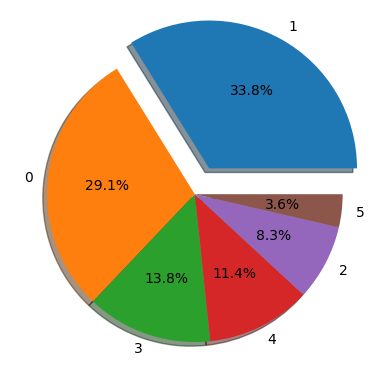

In [ ]:
myexplode = [0.2, 0, 0, 0, 0, 0]

# Generate the pie chart
plt.pie(
    x=df['label'].value_counts().values,  # Data values
    labels=df['label'].value_counts().index,  # Labels
    explode=myexplode,  # Explode
    shadow=True,  # Shadow effect
    autopct='%1.1f%%'  # Format for percentages
)

In [ ]:
for lab in (df['label'].unique()):
    print(str(lab)+'-------->'+str(100*df[df['label'] == lab].shape[0]/df.shape[0]))

0-------->29.074947997763964
1-------->33.84451871240784
2-------->8.29012809224369
3-------->13.751382527728527
4-------->11.446969715145306
5-------->3.5920529547106708


Removing unnecsssary words such as it,is,that...etc punctuation removal, tokenization

In [ ]:
import string
from nltk.corpus import stopwords

# Download the stopwords if you haven't already
import nltk
nltk.download('stopwords')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into words
    words = text.split()
    # Get the set of English stopwords
    stop_words = set(stopwords.words('english'))
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    return filtered_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['text_aft_stp_wds'] = df['text'].apply(preprocess_text)

We can see filtered text  as a new column which will be used to create document vectors for further analsys and model building

In [ ]:
df.head()

,text,label,text_aft_stp_wds
0,i feel awful about it too because it s my job ...,0,"[feel, awful, job, get, position, succeed, hap..."
1,im alone i feel awful,0,"[im, alone, feel, awful]"
2,ive probably mentioned this before but i reall...,1,"[ive, probably, mentioned, really, feel, proud..."
3,i was feeling a little low few days back,0,"[feeling, little, low, days, back]"
4,i beleive that i am much more sensitive to oth...,2,"[beleive, much, sensitive, peoples, feelings, ..."


In [ ]:
sentences = df['text_aft_stp_wds'].tolist()

In [ ]:
len(sentences)

416809

Training word2vec using gensim library

In [ ]:
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:

model.save('twitter_Word2Vec.model')



Generating document vector column in which a unique value is stored for each word in the given document

In [ ]:
def get_document_vector(text, model):
    # Get word vectors for the words in the document
    word_vectors = [model.wv[word] for word in text if word in model.wv]

    # If no word vectors exist (e.g., out-of-vocabulary words), return a zero vector
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Return a zero vector

    # Return the average of the word vectors
    return np.mean(word_vectors, axis=0)

# Generate document vectors for each row in the DataFrame using the pre-trained Word2Vec model
df['document_vector'] = df['text_aft_stp_wds'].apply(lambda x: get_document_vector(x, model))



In [ ]:
df_20000 = df.head(20000)

Model building using word2vec embeddings and neural networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:




X = df_20000['document_vector'].to_list()  #  list of numpy arrays
X = np.array([np.array(xi) for xi in X]) # Convert to 2D numpy array
y = df_20000['label'].values



In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Define the neural network model
class ModelBuilding(nn.Module):
    def __init__(self, in_feat, h1, h2, h3, ou_lay):
        super(ModelBuilding, self).__init__()
        self.fc1 = nn.Linear(in_feat, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, ou_lay)

    def forward(self, X): # Changed to 'forward' for PyTorch convention
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X



In [ ]:

# Create an instance of the model
torch.manual_seed(30)
model = ModelBuilding(100, 300, 200, 50, 6)



In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Training loop
epochs = 2000
losses = []
X_train = torch.tensor(X_train, dtype=torch.float32) # Convert to PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.long)    # Convert to PyTorch tensor

for i in range(epochs):
    i += 1
    y_pred = model(X_train)                      # Use 'model(X_train)' for forward pass
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())                  # Get the scalar value of the loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 1:
        print(f'Epoch: {i}, Loss: {loss.item()}')  # Print loss value

Epoch: 1, Loss: 1.7585524320602417
Epoch: 51, Loss: 1.0315250158309937
Epoch: 101, Loss: 0.7990067005157471
Epoch: 151, Loss: 0.6941874027252197
Epoch: 201, Loss: 0.601729154586792
Epoch: 251, Loss: 0.5236392617225647
Epoch: 301, Loss: 0.4568169116973877
Epoch: 351, Loss: 0.40040266513824463
Epoch: 401, Loss: 0.35697588324546814
Epoch: 451, Loss: 0.3354724049568176
Epoch: 501, Loss: 0.2815069258213043
Epoch: 551, Loss: 0.24896161258220673
Epoch: 601, Loss: 0.22043153643608093
Epoch: 651, Loss: 0.19414028525352478
Epoch: 701, Loss: 0.17269088327884674
Epoch: 751, Loss: 0.16824831068515778
Epoch: 801, Loss: 0.1365320086479187
Epoch: 851, Loss: 0.12160460650920868
Epoch: 901, Loss: 0.10675542056560516
Epoch: 951, Loss: 0.09316659718751907
Epoch: 1001, Loss: 0.08101938664913177
Epoch: 1051, Loss: 0.12002603709697723
Epoch: 1101, Loss: 0.07706430554389954
Epoch: 1151, Loss: 0.06848086416721344
Epoch: 1201, Loss: 0.06246570125222206
Epoch: 1251, Loss: 0.05714885890483856
Epoch: 1301, Loss: 0

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

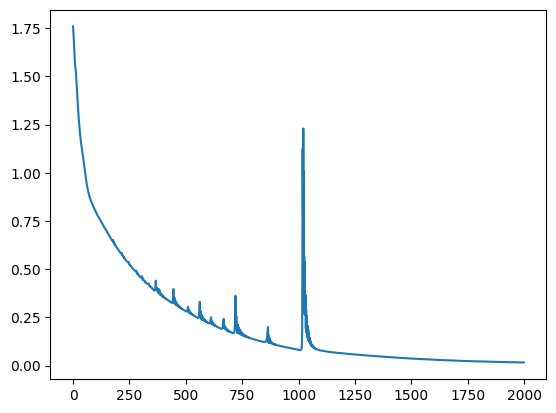

In [ ]:
plt.plot(range(epochs), losses)

In [ ]:
X_train = np.array(X_test)
y_train = np.array(y_test)
X_train = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_test, dtype = torch.int64)


In [ ]:
y_test_reset = pd.Series(y_test).reset_index() # Convert y_test to a pandas Series before resetting index

In [ ]:
y_test_reset.head()

,index,0
0,0,0
1,1,3
2,2,1
3,3,1
4,4,1


In [ ]:
c = 0
for i in range(len(y_test)):

    # Ensure X_test[i] is a tensor
    input_tensor = torch.tensor(X_test[i], dtype=torch.float32)

    # Add a batch dimension if necessary
    input_tensor = input_tensor.unsqueeze(0)  # Shape [1, features]

    # Predict
    y_t_predict = model(input_tensor).argmax(dim=1).item()

    # Compare predictions
    if y_t_predict == y_test[i].item():
        c += 1


In [ ]:
accuracy_test = 100*c/len(X_test)

We have got a decent accuracy using word2vec embeddings and neural network

In [ ]:
accuracy_test

70.575

**Using transformers distilbert embeddings and logistic regression for classifier **

In [ ]:
df_20000 = df.head(20000)

In [ ]:
!pip install transformers scikit-learn

import torch
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report



In [ ]:
 #Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
distilbert_model = DistilBertModel.from_pretrained(model_name)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Function to get document vectors (adapted for pandas apply)
def get_document_vector_apply(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
        doc_vector = outputs.last_hidden_state[:, 0, :].detach().numpy()  # Detach from PyTorch computation graph
    return doc_vector



In [ ]:
# Generate document vectors using pandas apply
df_20000['document_vector'] = df_20000['text'].apply(get_document_vector_apply)

# Extract features (X) and labels (y)
X = np.vstack(df_20000['document_vector'].to_numpy())
y = df_20000['label'].values



In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6455
              precision    recall  f1-score   support

           0       0.66      0.74      0.69      1210
           1       0.70      0.81      0.75      1300
           2       0.46      0.25      0.32       348
           3       0.57      0.51      0.54       528
           4       0.60      0.51      0.55       469
           5       0.54      0.32      0.40       145

    accuracy                           0.65      4000
   macro avg       0.59      0.52      0.54      4000
weighted avg       0.63      0.65      0.63      4000



Model building using distilbert embedings and neural network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
class ModelBuilding(nn.Module):
    def __init__(self, in_feat, h1, h2, h3, ou_lay):
        super(ModelBuilding, self).__init__()
        self.fc1 = nn.Linear(in_feat, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, ou_lay)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

# Create an instance of the model
torch.manual_seed(30)
# Get the input feature size from the shape of your DistilBERT vectors
in_feat = X_train.shape[1]
model = ModelBuilding(in_feat, 300, 200, 50, 6)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2000
losses = []

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 1:
        print(f'Epoch: {i}, Loss: {loss.item()}')

Epoch: 1, Loss: 1.7933176755905151
Epoch: 51, Loss: 1.297236442565918
Epoch: 101, Loss: 1.1207547187805176
Epoch: 151, Loss: 0.9753182530403137
Epoch: 201, Loss: 0.9077481627464294
Epoch: 251, Loss: 0.8401371240615845
Epoch: 301, Loss: 0.7826681733131409
Epoch: 351, Loss: 0.7226452827453613
Epoch: 401, Loss: 0.6765384674072266
Epoch: 451, Loss: 0.6260788440704346
Epoch: 501, Loss: 0.5964988470077515
Epoch: 551, Loss: 0.5515401363372803
Epoch: 601, Loss: 0.5089536905288696
Epoch: 651, Loss: 0.47228866815567017
Epoch: 701, Loss: 0.43975353240966797
Epoch: 751, Loss: 0.41659507155418396
Epoch: 801, Loss: 0.44276025891304016
Epoch: 851, Loss: 0.35968178510665894
Epoch: 901, Loss: 0.34190472960472107
Epoch: 951, Loss: 0.5313199758529663
Epoch: 1001, Loss: 0.3375152051448822
Epoch: 1051, Loss: 0.2904133200645447
Epoch: 1101, Loss: 0.2646861970424652
Epoch: 1151, Loss: 0.2572307884693146
Epoch: 1201, Loss: 0.23669156432151794
Epoch: 1251, Loss: 0.2111448347568512
Epoch: 1301, Loss: 0.19554911

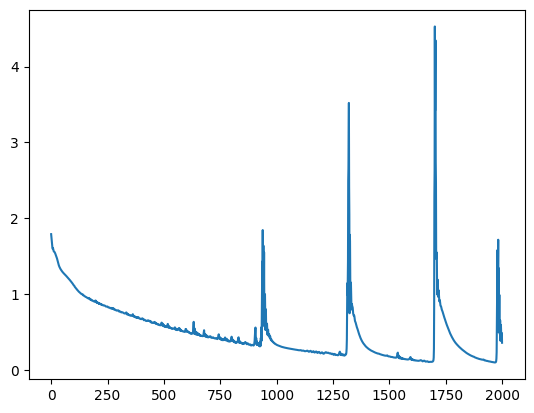

In [ ]:
plt.plot(range(epochs), losses)

In [ ]:
  from sklearn.metrics import accuracy_score, classification_report
  import torch

In [ ]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Or torch.int64 if needed

# Make predictions on the test set
with torch.no_grad():  # Disable gradient calculation during inference
    y_pred_test = model(X_test_tensor)

# Get predicted labels
predicted_labels = y_pred_test.argmax(dim=1).numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print classification report (optional)
print(classification_report(y_test, predicted_labels))

Test Accuracy: 59.48%
              precision    recall  f1-score   support

           0       0.62      0.69      0.66      1210
           1       0.69      0.73      0.71      1300
           2       0.39      0.35      0.37       348
           3       0.53      0.40      0.46       528
           4       0.48      0.48      0.48       469
           5       0.35      0.30      0.32       145

    accuracy                           0.59      4000
   macro avg       0.51      0.49      0.50      4000
weighted avg       0.59      0.59      0.59      4000



Comparing all 3 models word2vec embeddings with neural networks gives the most accurate results along with less computational time